# Generating relative value trade ideas using PCA

The goal of this exercise is to implement a framework for identifying and analyzing relative value trades using PCA and Python. 

## Setting it up

Let's first import the dependencies we will need. 

In [152]:
%matplotlib inline

import quandl

import numpy as np
from numpy import array
import pandas as pd
from operator import sub
import pickle
import math
import itertools as iter
import datetime as dt
import os

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import cm, rc
from mpl_toolkits.mplot3d import Axes3D

from sklearn.preprocessing import StandardScaler, normalize
from sklearn.decomposition import PCA, KernelPCA

from IPython.display import display, HTML


rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

print ("Loaded!")

cwd = os.getcwd()


Loaded!


We will be performing our exercise on the German yield curve from Quandl. Free data is available from January 2010 to December 2014.

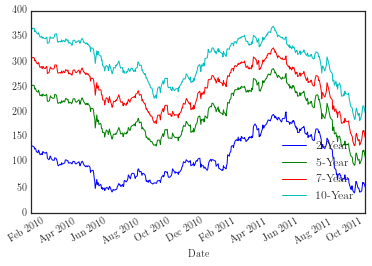

In [153]:
country = "DEU"
data = quandl.get("YC/"+country, authtoken="hHmwzKyDyqaHhJLF1eFe")

#Let's focus on 2y, 5y, 7y, 10y, 20y and 30y
assets = ['2-Year', '5-Year', '7-Year', '10-Year']
data = data[assets]

#convert to bps
data *= 100

start = dt.datetime(2010, 1, 4)
end = dt.datetime(2011, 10, 3)

data = data[start:end]

data.plot()


## change dates

## Writing the static PCA function

We'll try to write a function staticPCA. It takes in our raw data, number of components we are interested in (default 4) and resample frequency on the raw data (default 1). It also takes in corrW (default 20), which is used to determine how many periods to use in the rolling correlation of reconstructed factors.

The output of the function will be a dictionary of resultant eigenvalues, eigenvectors, the covariance matrix, and historical reconstructed factors.

Further down the line, we will also need k-factor residuals (residuals found by reconstructing the data using only k-1 factors). We write this helper function and use it in the staticPCA function now, to make things a bit easier.

In [154]:
def kfacReconstruct(data, evTable, k=3):
    # Returns k-factor reconstruction when given the data and Eigenvectors
    
    result = {}
    
    totFactors = len(evTable.columns.values)
    if totFactors < k:
        print ("Error! Total factors are less than k.")
        return
    
    # get demeaned data
    meanVals = data.mean()
    demeaned = data - meanVals
    
    #reconstruct historical factor time series
    factorTS = demeaned.dot(evTable)
    
    #inverse of eigenvectors
    invEV = pd.DataFrame(np.linalg.pinv(evTable.values), evTable.columns, evTable.index)

    #drop columns to adjust for k factors
    factorTS.drop(factorTS.columns[range(len(factorTS.columns.values))[k:]], axis=1, inplace=True)
    
    #drop rows to adjust for k factors
    invEV.drop(invEV.index[range(len(invEV.index.values))[k:]], axis=0, inplace=True)
    
    #### Reconstruction using k factors
    kRebuild = factorTS.dot(invEV)
    kResiduals = demeaned - kRebuild
    
    result["factorTS"] = factorTS
    result["rebuildRaw"] = kRebuild + meanVals
    result["residuals"] = kResiduals
    
    return result
    

def staticPCA(data, n=3, freq=1, corrW = 12):
    '''
    This function returns a dictionary with the following key value combinations:
    key    | Value
    raw    | DF with raw data (as resampled)
    covM   | Covariance matrix of raw data
    evals  | n eigenvalues
    evecs  | n eigenvectors
    facTS  | time series of reconstructed factors using raw data. 
    reRaw  | Rebuilt raw data from n EVs, and accompanying residuals
    resid  | Residuals (Actual - Reconstructed)
    facCR  | Rolling cross correlations between factors
    '''
    results = {}
    
    ## resample data based on freq and calc demeaned data
    raw = data.iloc[::freq, :]
    results["rawDat"] = raw
    meanVals = raw.mean()
    demeaned = raw - meanVals
    
    ## Covariance Matrix
    covM = raw.cov()
    results["covM"] = covM

    ## PCA
    evals, evecs = np.linalg.eig(covM)
    epairs = [(np.abs(evals[i]), evecs[:,i]) for i in range(len(evals))]
    epairs.sort(key=lambda x: x[0], reverse=True)
    evals = sorted([i*100/sum(evals) for i in evals])[::-1][:n]
    results["evals"] = evals

    evTable = pd.DataFrame(index=covM.index)
    for i in range(n):
        evTable.insert(i, "PC"+str(i+1), epairs[i][1])
    results["evecs"] = evTable

    ## Reconstruct
    reconstructed = kfacReconstruct(raw, evTable, n)
    resid = reconstructed["residuals"]
    facTS = reconstructed["factorTS"]
    reRaw = reconstructed["rebuildRaw"]
    
    results["resid"] = resid
    results["facTS"] = facTS
    results["reRaw"] = reRaw
    

    ## Rolling correlations of factors
    facCR = pd.DataFrame()
    combos =[facTS[list(pair)] for pair in list(iter.combinations(facTS.columns, 2))]
    for df in combos:
        cols = df.columns.values
        facCR["".join(cols)] = facTS[cols[0]].rolling(window=corrW).corr(other=facTS[cols[1]])

    results["facCR"] = facCR
    return results




## Playing around with the function results

Let's load our German Yield curve data into this function and see what we get.

Eigenvectors:


,PC1,PC2,PC3
2-Year,0.438234,0.820231,0.353456
5-Year,0.536120,0.054305,-0.630920
7-Year,0.525500,-0.265548,-0.254924
10-Year,0.494344,-0.503742,0.641890


Eigenvalues:


[91.339485460872737, 8.5440018346113753, 0.10867269358368825]

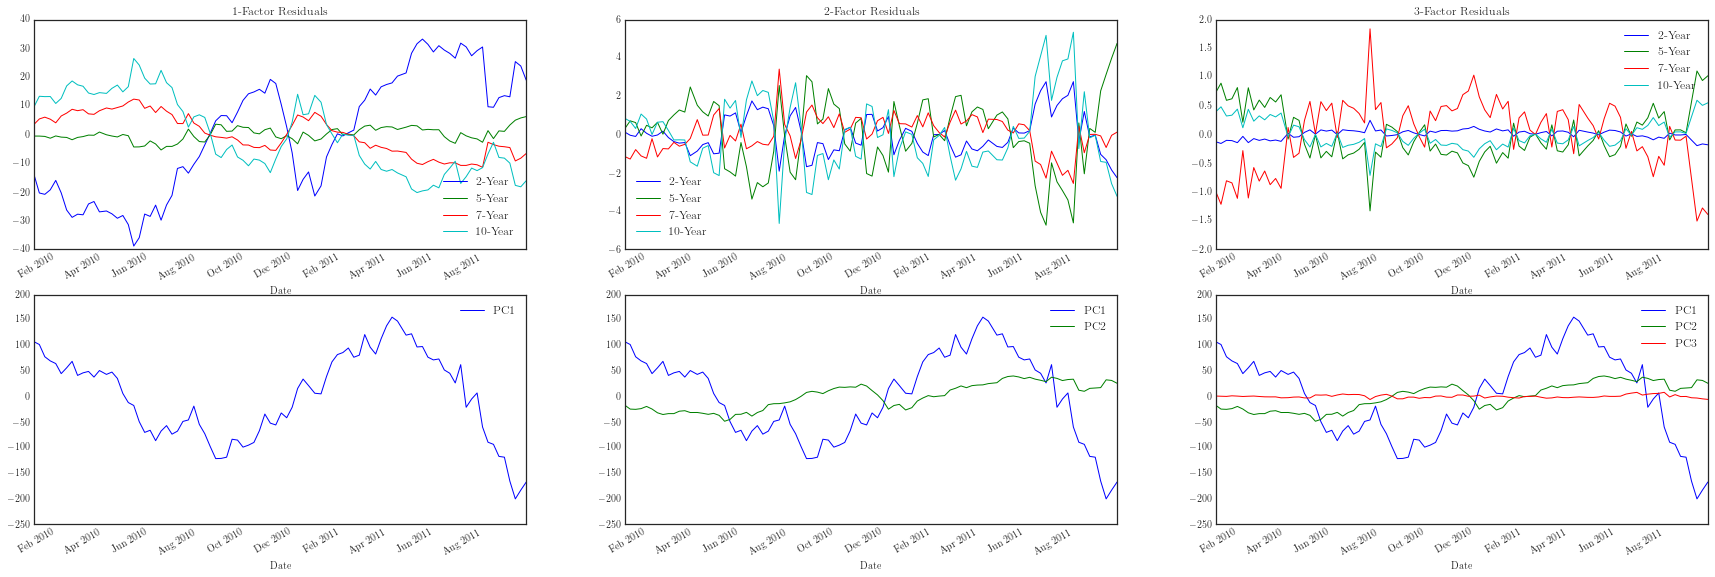

In [158]:
print("Eigenvectors:")
pca3 = staticPCA(data, freq=5, n=3)
display(pca3["evecs"])
print("Eigenvalues:")
display(pca3["evals"])


fig, axes = plt.subplots(nrows=2, ncols=3)
fig.set_size_inches(30, 10)
    
pca1["resid"].plot(ax=axes[0, 0], title="1-Factor Residuals")
pca1["facTS"].plot(ax=axes[1, 0])

pca2["resid"].plot(ax=axes[0, 1], title="2-Factor Residuals")
pca2["facTS"].plot(ax=axes[1, 1])

pca3["resid"].plot(ax=axes[0, 2], title="3-Factor Residuals")
pca3["facTS"].plot(ax=axes[1, 2])

# Residuals

We create a one page summary of the residuals, which might potentially highlight attractive trades.


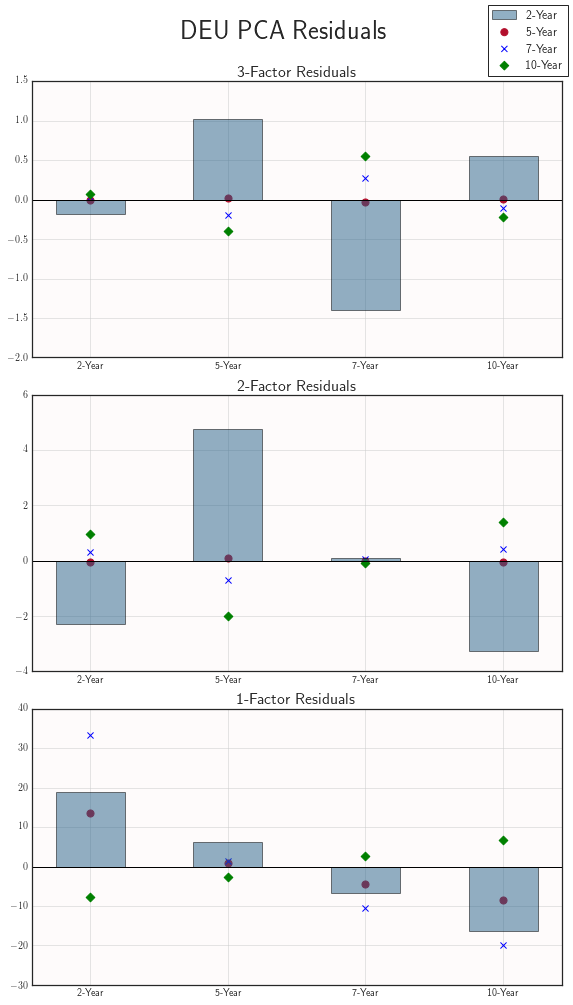

In [12]:
########### Residuals ############
## LEVEL
xvals = range(len(assets))

relVal1 = pd.DataFrame()
relVal1 = pca1["resid"].ix[[-1, -5, -20, -60]]
relVal1.index = ["1d", "1w", "1m", "3m"]
relVal1 = relVal1.transpose()

plt.style.use('seaborn-white')
fig = plt.figure(figsize=(8, 14), dpi=400)
fig.suptitle("%s PCA Residuals"%country, fontsize=26)

### 1-Factor PCA residual 
ax1 = plt.subplot2grid((3, 1), (2, 0), colspan=1)
xvals = range(len(assets))
lday=ax1.bar(xvals, relVal1["1d"], alpha=0.5,color='#256189', align='center', width=0.5, label='1d')
ax1.set_xticks(xvals)
ax1.set_xticklabels(assets)
plt.grid()
s = 25
lwk= ax1.scatter(xvals, relVal1["1w"], color='#B20F2C', marker = "o", s=2*s, label='1w')
lmnth=ax1.scatter(xvals, relVal1["1m"], color='b', marker = "x", s=1.5*s, label="1m")
lquart=ax1.scatter(xvals, relVal1["3m"], color='g', marker = "D", s=1.5*s, label="3m")
ax1.axhline(0, color="black")
ax1.set_title("1-Factor Residuals", fontsize="16")
ax1.set_axis_bgcolor('#FEFBFB')


## 2-Factor PCA residual

relVal2 = pd.DataFrame()
relVal2 = pca2["resid"].ix[[-1, -5, -20, -60]]
relVal2.index = ["1d", "1w", "1m", "3m"]
relVal2 = relVal2.transpose()

ax2 = plt.subplot2grid((3, 1), (1, 0), colspan=1)
ax2.bar(xvals, relVal2["1d"], alpha=0.5,color='#256189', align='center', width=0.5, label='1d')
ax2.set_xticks(xvals)
ax2.set_xticklabels(assets)
plt.grid()
s = 25
ax2.scatter(xvals, relVal2["1w"], color='#B20F2C', marker = "o", s=2*s, label='1w')
ax2.scatter(xvals, relVal2["1m"], color='b', marker = "x", s=1.5*s, label="1m")
ax2.scatter(xvals, relVal2["3m"], color='g', marker = "D", s=1.5*s, label="3m")
ax2.axhline(0, color="black")
ax2.set_title("2-Factor Residuals", fontsize="16")
ax2.set_axis_bgcolor('#FEFBFB')


## 3-Factor PCA residual


relVal3 = pd.DataFrame()
relVal3 = pca3["resid"].ix[[-1, -5, -20, -60]]
relVal3.index = ["1d", "1w", "1m", "3m"]
relVal3 = relVal3.transpose()

ax3 = plt.subplot2grid((3, 1), (0, 0), colspan=1)
ax3.bar(xvals, relVal3["1d"], alpha=0.5,color='#256189', align='center', width=0.5, label='1d')
ax3.set_xticks(xvals)
ax3.set_xticklabels(assets)
plt.grid()
s = 25
ax3.scatter(xvals, relVal3["1w"], color='#B20F2C', marker = "o", s=2*s, label='1w')
ax3.scatter(xvals, relVal3["1m"], color='b', marker = "x", s=1.5*s, label="1m")
ax3.scatter(xvals, relVal3["3m"], color='g', marker = "D", s=1.5*s, label="3m")
ax3.axhline(0, color="black")
ax3.set_title("3-Factor Residuals", fontsize="16")
ax3.set_axis_bgcolor('#FEFBFB')


fig.tight_layout()
fig.subplots_adjust(top=0.92)
plt.figlegend([lday, lwk, lmnth, lquart], relVal1.index.values, frameon=True,loc="upper right" )
plt.savefig("%s/depo/PCA Residuals - %s"%(cwd,(data.index[-1].strftime("%d %b %y"))))


At the end of the exercise, we will dive quite a bit deeper into the results. For now, let's go back implement a rolling PCA using our staticPCA function.

# Rolling PCA

Here we try to implement a rolling PCA in order to study the stability of eigenvectors and eigenvalues over time.


In [181]:
def rollingPCA(data, lb=30, n=3, freq=1, corrW=12, skip=1):
    """
    For now, this function returns a data frame with time series of eigenvalues and eigenvectors of a rolling PCA. 
    """
    lb = 30
    n=3
    freq=1
    corrW=12
    skip=1

    rollResult = {}
    
    assets = data.columns.values
    pcCols = ["PC"+str(i+1) for i in range(n)]
    eVecCols = [pc+asset for pc in pcCols for asset in assets]
    
    # Create dataframe for results. 
    accumEvals = pd.DataFrame(columns = range(1, n+1), index=data.index.values[lb:])
    accumEvecs = dict.fromkeys(pcCols, pd.DataFrame(columns=assets, index=data.index.values[lb:]))
    alleVectors = pd.DataFrame(index=data.index.values[lb:], columns = eVecCols)
    
    ### Rolling PCA - Loop and save data.
    
    for i in range(0, len(data.index)-lb, skip):
        
        temp = data[i:lb+i]
        currDate = data.index.values[lb+i]
        res = staticPCA(temp, n=n, freq=freq, corrW=corrW)

        ## Save eigenvalues
        eigenvalues = res["evals"]
        for j in range(len(eigenvalues)):
            accumEvals.set_value(currDate,j+1,eigenvalues[j])

        ## Save eigenvectors
        eigenvectors = res["evecs"]
        tempDict = {}
        for pc in pcCols:
            factor = eigenvectors[pc]
            #print (i, pc, factor.tolist())
            for k in range(len(assets)):
                alleVectors.set_value(currDate, pc+assets[k], factor[k])
    
    #### Split data into PC1, PC2, PC3 and drop NAs.
    
    accumEvals = accumEvals.dropna()

    grouped = alleVectors.groupby(lambda x: x[:3], axis=1)
    
    for pc in pcCols:
        accumEvecs[pc] = grouped.get_group(pc).dropna()
        accumEvecs[pc].rename(columns=lambda x: x[3:], inplace=True)
    accumEvals.columns = pcCols
    rollResult["evectors"] = accumEvecs
    rollResult["evalues"] = accumEvals
    
    return rollResult
            
pcaResults = rollingPCA(data)
print ("Done!")


Done!


Let's see what the eigenvalues and eigenvectors look like over time. Their stability would highlight the effectiveness of the PCA based model for this particular set of data.

Eigenvalues:


,PC1,PC2,PC3
2011-09-27,98.5754,1.19602,0.221682
2011-09-28,98.4279,1.30087,0.26236
2011-09-29,98.1688,1.52465,0.296278
2011-09-30,98.0671,1.60063,0.321354
2011-10-03,97.9193,1.69283,0.377162


####### PC1 historical ########
              2-Year    5-Year    7-Year   10-Year
2011-09-27  0.302471  0.467601  0.563104  0.610552
2011-09-28  0.304386  0.468661  0.563423  0.608491
2011-09-29  0.303984  0.471482  0.565034  0.605008
2011-09-30  0.305754  0.473902  0.565017  0.602235
2011-10-03  0.308144  0.475705  0.564394  0.600176
####### PC2 historical ########
              2-Year    5-Year    7-Year   10-Year
2011-09-27  0.826851  0.254968 -0.131293 -0.483809
2011-09-28  0.826322  0.253841 -0.134342 -0.484468
2011-09-29  0.808993  0.276314 -0.127226 -0.502986
2011-09-30   0.80413  0.279464 -0.126933  -0.50908
2011-10-03  0.781417  0.302694  -0.11438 -0.533555
####### PC3 historical ########
              2-Year    5-Year    7-Year   10-Year
2011-09-27  0.448316 -0.570362  -0.38544  0.570208
2011-09-28  0.451429  -0.58582 -0.366375   0.56462
2011-09-29  0.483513 -0.586913 -0.353623    0.5447
2011-09-30  0.490915 -0.586505 -0.350119  0.540769
2011-10-03  0.526365 -0.580823 -0.346

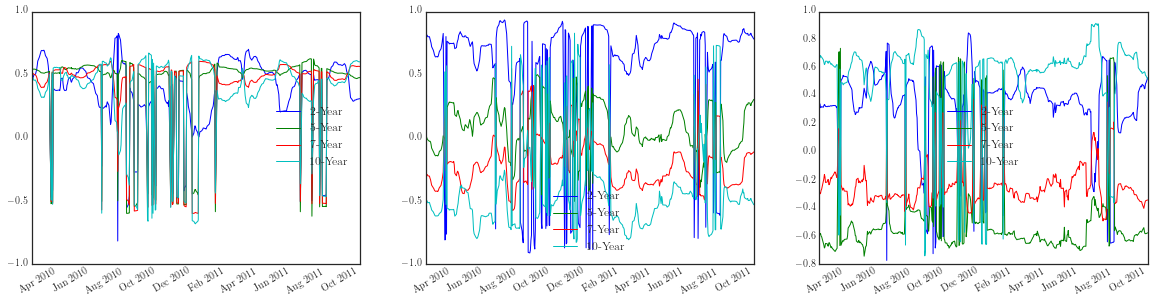

In [182]:

print ("Eigenvalues:")
display(pcaResults["evalues"].tail())
print ("####### PC1 historical ########")
print (pcaResults["evectors"]["PC1"].tail())
print ("####### PC2 historical ########")
print (pcaResults["evectors"]["PC2"].tail())
print ("####### PC3 historical ########")
print (pcaResults["evectors"]["PC3"].tail())

pc1raw = pcaResults["evectors"]["PC1"]
pc2raw = pcaResults["evectors"]["PC2"]
pc3raw = pcaResults["evectors"]["PC3"]

fig, axes = plt.subplots(nrows=1, ncols=3)
fig.set_size_inches(20, 5)

pc1raw.plot(ax=axes[0])
pc2raw.plot(ax=axes[1])
pc3raw.plot(ax=axes[2])


Wait, what? 

Ok, so this is because the static PCAs that are being run sometimes will generate eigenvectors that are in the opposite orientation of the previous eigenvector. But this isn't really a point to worry about. Eigenvectors would be equivalent to their negatives. What we can do, however, is to try our best to flip the eigenvectors to the direction that makes sense. 

The following function tries to achieve this task. It is not perfect, but it does not affect the purposes of the exercise (which is to determine the stability of the EVs). The stability is discernible well enough with the smoothing applied.

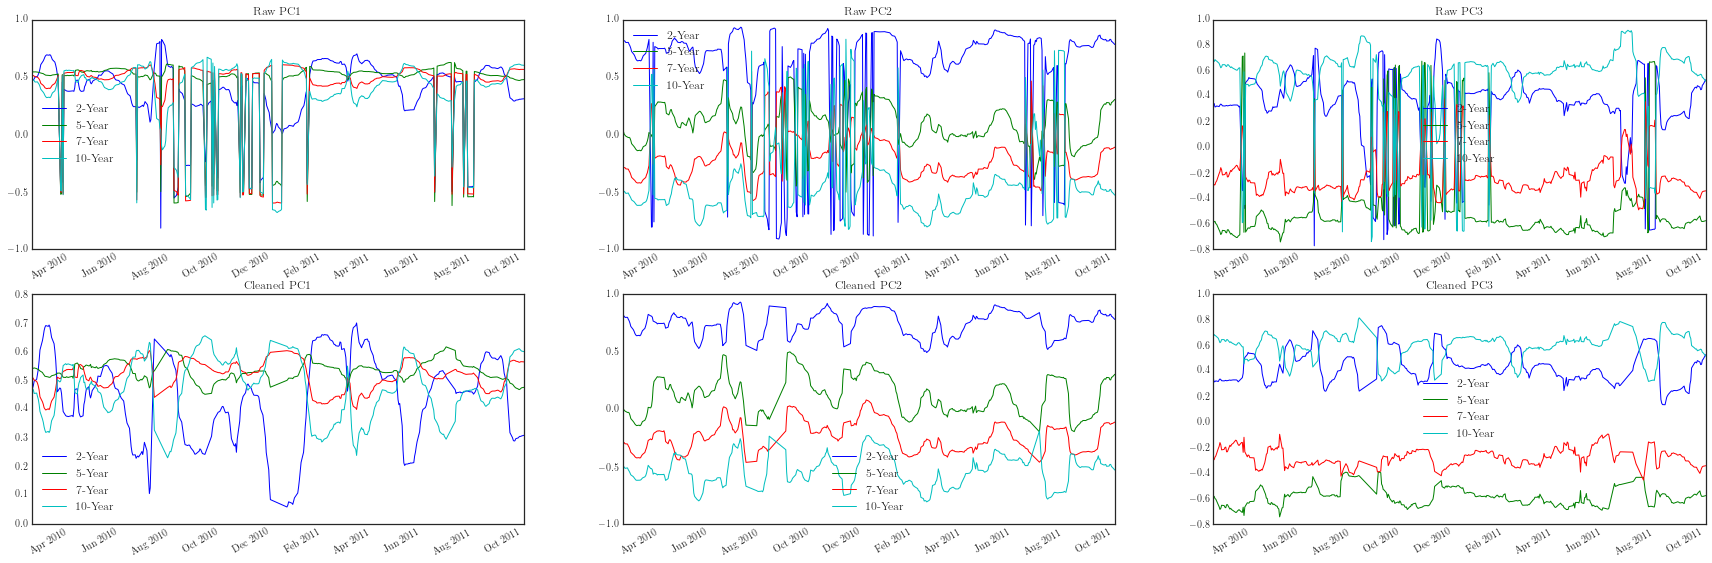

In [183]:

def cleanPCs(input, smoothing=1):
    newdf = pd.DataFrame(index=input.index.values, columns=input.columns.values)
    flag = "flipped"

    for i in range(1, len(input)):
        if i ==1:
            prevfactor = input.iloc[i-1]
        else:
            prevfactor = newdf.iloc[i-1]
        factor = input.iloc[i]
        negfactor = [-i for i in factor.tolist()]

        orig = sum([np.abs(x) for x in (factor-prevfactor).tolist()])
        new = sum([np.abs(x) for x in (-factor-prevfactor).tolist()])
        
        if orig > new:
            for s in range(len(input.columns.values)):
                newdf.set_value(newdf.index.values[i], newdf.columns.values[s], -1*input.iloc[i, s])
                flag = "flipped"
        else:
            for s in range(len(input.columns.values)):
                newdf.set_value(newdf.index.values[i], newdf.columns.values[s], input.iloc[i, s])
                flag = "same"
    
    if smoothing==1:
        newdf = newdf[newdf.apply(lambda x: np.abs(x - x.mean()) / x.std() < 2.5).all(axis=1)]
        newdf = newdf[newdf.apply(lambda x: np.abs(x - x.mean()) / x.std() < 2.5).all(axis=1)]

        
    return newdf
            

fig, axes = plt.subplots(nrows=2, ncols=3)
fig.set_size_inches(30, 10)
    
pc1raw.plot(ax=axes[0, 0], title="Raw PC1")
cleanPCs(pc1raw).plot(ax=axes[1, 0], title="Cleaned PC1")

pc2raw.plot(ax=axes[0, 1], title="Raw PC2")
cleanPCs(pc2raw).plot(ax=axes[1, 1], title="Cleaned PC2")

pc3raw.plot(ax=axes[0, 2], title="Raw PC3")
cleanPCs(pc3raw).plot(ax=axes[1, 2], title="Cleaned PC3")

Ah, much better. As we can see, the PCs are generally quite stable, with stability increasing with order. 

What about the Eigenvalues?

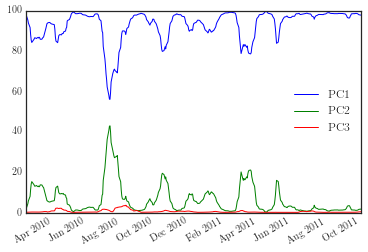

In [184]:
pcaResults["evalues"].plot()

Not too bad. 

# Generating weights for curve and fly trades

The next thing to do is create a function that would generated trades that are PC hedged. 